# Tracking Hydrothermal Diffuse Flow with Multibeam Sonar: Insights from COVIS

### This notebook contains the code used for data preparation, analysis, and visualization for my thesis titled "Tracking Hydrothermal Diffuse Flow with Multibeam Sonar: Insights from COVIS (2019-2023).

# Imports

In [1]:
# ---------------------------------------------------------------------------------------
# Imports
# ---------------------------------------------------------------------------------------
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from datetime import datetime
import glob
from io import StringIO
import numpy as np
import os
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
%matplotlib inline
import requests
import scipy.io as sio

from astropy.timeseries import LombScargle
from pygam import LinearGAM, s
from scipy.optimize import curve_fit
from scipy.signal import correlate
from scipy.signal import detrend
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import grangercausalitytests


# Data Load & Processing

### Hydrothermal Diffuse Flow: Heat Flux Density & Fractional Area data

In [2]:
# ---------------------------------------------------------------------------------------
# Heat Flux & Fractional Area data load and processing
# ---------------------------------------------------------------------------------------

# Define the path to the directory containing the .mat files.
path = 'heat_flux_results/'

# Use glob to find all .mat files matching the source data filename pattern (e.g., 'heat_flux_density_sector_1*.mat').
file_pattern = os.path.join(path, 'heat_flux_density_sector_1*.mat')
mat_files = sorted(glob.glob(file_pattern))
no_files = len(mat_files)

# Initialize lists to store computed values and date information.
q_av_list = []       # List for average heat flux density (W/m^2)
A_fract_list = []    # List for fractional active area
year_list = []       # List for years extracted from filenames
month_list = []      # List for months extracted from filenames
day_list = []        # List for days extracted from filenames

# Loop over each .mat file.
for i, filename in enumerate(mat_files):
    # Load the .mat file using SciPy. This returns a dictionary containing variables.
    data = sio.loadmat(filename)
    
    # Extract variables 'x', 'y', and 'q_trim' from the loaded data.
    x = data['x']
    y = data['y']
    q_trim = data['q_trim']  # This should be a 2D NumPy array representing heat flux density.
    
    # For the first file, compute grid spacing and the polar coordinate arrays (r and phi)
    # that are assumed to be the same for all files.
    if i == 0:
        # Compute grid spacing in x and y directions.
        # MATLAB uses 1-indexing (x(1,2)-x(1,1)); here we use 0-indexing.
        delx = x[0, 1] - x[0, 0]
        dely = y[1, 0] - y[0, 0]
        
        # Compute the radial distance from the origin for each grid point.
        r = np.sqrt(x**2 + y**2)
        
        # Compute the angle in degrees.
        # Note: MATLAB uses 'atan2(x,y)' here, although the typical order is (y,x).
        # To mimic the MATLAB behavior exactly, call np.arctan2(x, y) (even though
        # NumPy’s arctan2 convention is arctan2(y, x)).
        phi = 180 / np.pi * np.arctan2(x, y)
    
    # -----------------------------------------------------------
    # Trim regions corresponding to the 'Mushroom' and 'Inferno' shadows.
    # -----------------------------------------------------------
    
    # ----- Mushroom Shadow Trimming -----
    # Compute the minimum radial distance using the Euclidean norm of [-3.75, 7.25].
    rmin_mush = np.linalg.norm(np.array([-3.75, 7.25]))
    # Compute the minimum and maximum angles (in degrees) defining the Mushroom region.
    phi_min_mush = 180 / np.pi * np.arctan2(-13.75, 11.75)
    phi_max_mush = 180 / np.pi * np.arctan2(-8.75, 18.25)
    # Create a boolean mask for grid points that satisfy the Mushroom shadow criteria.
    mushroom_mask = (phi > phi_min_mush) & (phi < phi_max_mush) & (r > rmin_mush)
    # Set the q_trim values in the Mushroom region to NaN to exclude these points.
    q_trim[mushroom_mask] = np.nan

    # ----- Inferno Shadow Trimming -----
    # Define the minimum radial distance for the Inferno region.
    rmin_inferno = 11.25
    # Compute the angular bounds (in degrees) for the Inferno region.
    phi_min_inferno = 180 / np.pi * np.arctan2(-19.25, -4.75)
    phi_max_inferno = 180 / np.pi * np.arctan2(-18.75, 4.25)
    # Create a mask for the Inferno region.
    inferno_mask = (phi > phi_min_inferno) & (phi < phi_max_inferno) & (r > rmin_inferno)
    # Exclude these points by setting them to NaN.
    q_trim[inferno_mask] = np.nan

    # -----------------------------------------------------------
    # Calculate total power, active area, and effective area.
    # -----------------------------------------------------------
    
    # Make a copy of q_trim for further calculations.
    q_trimm = q_trim.copy()
    # Identify where q_trimm is NaN.
    nan_mask = np.isnan(q_trimm)
    # Replace NaNs with 0 for the power calculation.
    q_trimm[nan_mask] = 0
    # Compute the total power (W) by summing q_trimm and multiplying by the area element.
    P = delx * dely * np.sum(q_trimm)
    
    # ----- Total Active Area Calculation -----
    # To compute the total active area, we want to count grid points where the heat flux is defined.
    # Create a temporary copy and set the previously NaN points to -1.
    # The sign function will yield -1 for these, and 0.5*(sign+1) will then give 0.
    q_temp = q_trimm.copy()
    q_temp[nan_mask] = -1
    # The total area A is the sum over grid points (each contributing an area of delx*dely)
    # where the heat flux is defined (i.e., where q_temp is positive).
    A = delx * dely * np.sum(0.5 * (np.sign(q_temp) + 1))
    
    # ----- Effective Area Calculation -----
    # The effective area is defined using the formula:
    #   A_eff = (delx*dely)*(sum(q_trimm)^2) / sum(q_trimm^2)
    # This weights the area by the distribution of heat flux.
    A_eff = delx * dely * (np.sum(q_trimm) ** 2) / np.sum(q_trimm ** 2)
    
    # -----------------------------------------------------------
    # Compute the average heat flux density and fractional active area.
    # -----------------------------------------------------------
    
    # Average heat flux density (W/m^2) is the total power divided by the total active area.
    q_av = P / A
    # Fractional Active Area is defined as the ratio of the effective area to the total active area.
    A_fract = A_eff / A
    
    # Append the computed values to their respective lists.
    q_av_list.append(q_av)
    A_fract_list.append(A_fract)
    
    # -----------------------------------------------------------
    # Extract date information from the filename.
    # -----------------------------------------------------------
    # In the MATLAB code, the year is taken from characters 34-37, month from 38-39,
    # and day from 40-41. Adjusting for Python's 0-indexing:
    #   Year: indices 33 to 37, Month: indices 37 to 39, Day: indices 39 to 41.
    base_filename = os.path.basename(filename)
    year_str = base_filename[33:37]
    month_str = base_filename[37:39]
    day_str = base_filename[39:41]
    # Convert the extracted strings to integers.
    year_list.append(int(year_str))
    month_list.append(int(month_str))
    day_list.append(int(day_str))

# -----------------------------------------------------------
# Create datetime objects for plotting based on the extracted dates.
# -----------------------------------------------------------
t_plot = [datetime(y, m, d) for y, m, d in zip(year_list, month_list, day_list)]

# Create a Pandas dataframe
heatflux_df = pd.DataFrame({
    'Date': t_plot,  # Already in datetime format
    'Heat Flux Density (kW/m²)': np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    'Fractional Area': A_fract_list
})

# Print the dataframe
print(heatflux_df)

# Save the dataframe to a CSV file
csv_filename = 'heat_flux_density_data.csv'
heatflux_df.to_csv(csv_filename, index=False)  # Save without the index column
print(f'Data saved to {csv_filename}')

           Date  Heat Flux Density (kW/m²)  Fractional Area
0    2019-07-06                 290.943743         0.741085
1    2019-07-07                 278.033048         0.740710
2    2019-07-08                 363.147219         0.551261
3    2019-07-09                 258.638493         0.684327
4    2019-07-10                 257.008937         0.682457
...         ...                        ...              ...
1209 2023-09-12                 332.356029         0.731996
1210 2023-09-13                 402.929219         0.775075
1211 2023-09-14                 349.966101         0.724894
1212 2023-09-15                 321.318504         0.673967
1213 2023-09-16                 331.449023         0.714378

[1214 rows x 3 columns]
Data saved to heat_flux_density_data.csv


### Seismic Activity data

In [3]:
# ---------------------------------------------------------------------------------------
# Seismic activity by day (from text file)
# ---------------------------------------------------------------------------------------

# Define colspecs and names (based on exact spacing)
colspecs = [
    (0, 8),     # yyyymmdd
    (9, 19),    # HHMMSSS.SS
    (20, 22),   # Lat degrees
    (23, 28),   # Lat minutes
    (29, 32),   # Lon degrees
    (33, 38),   # Lon minutes
    (39, 45),   # Depth
    (45, 52),   # MW
    (52, 55),   # NWR
    (55, 59),   # GAP
    (59, 64),   # DMIN
    (64, 69),   # RMS
    (69, 74),   # ERH
    (74, 79),   # ERZ
    (79, 93),   # ID
    (93, 106),  # PMom
    (106, 115)  # SMom
]

column_names = [
    'date_str', 'time_str', 'lat_deg', 'lat_min', 'lon_deg', 'lon_min',
    'depth', 'mw', 'nwr', 'gap', 'dmin', 'rms', 'erh', 'erz', 'id', 'pmom', 'smom'
]

# -----------------------------------------------------------
# Select one data load option to use
# -----------------------------------------------------------
# OPTION 1: Data load from URL
url = 'http://axial.ocean.washington.edu/hypo71.dat'
response = requests.get(url)
lines = response.text.splitlines()

# Filter valid lines (those that start with 4-digit year)
valid_lines = [line for line in lines if line[:4].isdigit()]
data_str = '\n'.join(valid_lines)

# Read file with dtype override for date/time columns
df_seismic = pd.read_fwf(
    StringIO(data_str),
    colspecs=colspecs,
    names=column_names,
    dtype={'date_str': str, 'time_str': str})
# -------------------------------------------------
# # OPTION 2: Data load from text file
# df_seismic = pd.read_fwf(
#     'volcanic & seismic data/hypo71.dat.txt',
#     colspecs=colspecs,
#     names=column_names,
#     dtype={'date_str': str, 'time_str': str},
#     skiprows=1  # skip header line
# )
# -----------------------------------------------------------

# Parsing date and time
df_seismic['year'] = df_seismic['date_str'].str[0:4].astype(int)
df_seismic['month'] = df_seismic['date_str'].str[4:6].astype(int)
df_seismic['day'] = df_seismic['date_str'].str[6:8].astype(int)

df_seismic['hour'] = df_seismic['time_str'].str[0:2].astype(int)
df_seismic['minute'] = df_seismic['time_str'].str[2:4].astype(int)
df_seismic['second'] = pd.to_numeric(df_seismic['time_str'].str[4:], errors='coerce')

# Convert lat/lon to decimal degrees
df_seismic['latitude'] = df_seismic['lat_deg'] + df_seismic['lat_min'] / 60.0
df_seismic['longitude'] = -(df_seismic['lon_deg'].abs() + df_seismic['lon_min'] / 60.0)

# Create datetime column
df_seismic['datetime'] = pd.to_datetime(
    df_seismic[['year', 'month', 'day', 'hour', 'minute']], errors='coerce'
)
df_seismic['Date'] = pd.to_datetime(df_seismic['datetime'].dt.date)

# Convert numeric fields
numeric_cols = ['depth', 'mw', 'nwr', 'gap', 'dmin', 'rms', 'erh', 'erz', 'pmom', 'smom']
df_seismic[numeric_cols] = df_seismic[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop invalid dates
df_seismic.dropna(subset=['datetime'], inplace=True)

# Aggregate seismic events per day
daily_seismic_counts = df_seismic.groupby('Date').size().reset_index(name='Seismic Count')

# Print the aggregated daily counts
print(daily_seismic_counts)

# Get the min and max dates from heatflux_df index
min_date = heatflux_df['Date'].min()
max_date = heatflux_df['Date'].max()

# Filter data to heatflux_df date range
daily_seismic_counts_filtered = daily_seismic_counts[(daily_seismic_counts['Date'] >= min_date) & (daily_seismic_counts['Date'] <= max_date)]

# Print the filtered aggregated daily counts
print(daily_seismic_counts_filtered)

           Date  Seismic Count
0    2015-01-22             67
1    2015-01-23             71
2    2015-01-24            151
3    2015-01-25            100
4    2015-01-26            350
...         ...            ...
3649 2025-10-20             32
3650 2025-10-21             20
3651 2025-10-22             10
3652 2025-10-23             20
3653 2025-10-24            111

[3654 rows x 2 columns]
           Date  Seismic Count
1491 2019-07-06              4
1492 2019-07-07              5
1493 2019-07-08              6
1494 2019-07-09              2
1495 2019-07-10              2
...         ...            ...
2906 2023-09-12             11
2907 2023-09-13             13
2908 2023-09-14              9
2909 2023-09-15            145
2910 2023-09-16             43

[1420 rows x 2 columns]


### Volcanic Inflation data

#### Bottom Pressure Recorder data from MJ03B

In [4]:
# ---------------------------------------------------------------------------------------
# Bottom Pressure Recorder data by day
# ---------------------------------------------------------------------------------------

# Path to volcanic inflate data files
data_folder = 'volcanic & seismic data/Volcanic/BPR/'

# Pattern matching your filenames
files = sorted(glob.glob(os.path.join(data_folder, 'MJ03B*NANO.Data')))

# List to store individual DataFrames
df_list = []

# Loop through each file and process
for file in files:
    print(f'Processing {file}...')

    # Read data directly with correct parsing (no deprecated arguments)
    temp_df = pd.read_csv(
        file,
        sep=',',
        header=None,
        names=['datetime', 'raw_pressure_psi', 'de_tided_depth_m', 'temperature_C'],
        parse_dates=['datetime']  # directly parse datetime
    )

    # Append processed DataFrame to list
    df_list.append(temp_df)

# Combine into single DataFrame
df_volcanic = pd.concat(df_list, ignore_index=True)

# Set datetime as index
df_volcanic.set_index('datetime', inplace=True)

# Check combined data
print(df_volcanic.head())

# Resample to daily mean
daily_avg_volcanic = df_volcanic.resample('D').mean()

# Set index name for clarity
daily_avg_volcanic.index.name = 'Date'

# Limit daily mean volcanic inflation data to date and de-tided depth
daily_avg_volcanic_de_tided = daily_avg_volcanic[['de_tided_depth_m']].copy().rename(columns={'de_tided_depth_m': 'De-Tided Depth (m)'})

# Check average data
print(daily_avg_volcanic.head())

# Display daily average de-tided depth
daily_avg_volcanic_de_tided

# Get the min and max dates from heatflux_df index
min_date = heatflux_df['Date'].min()
max_date = heatflux_df['Date'].max()


# Filter data to heatflux_df date range
daily_avg_volcanic_de_tided_filtered = daily_avg_volcanic_de_tided[(daily_avg_volcanic_de_tided.index >= min_date) & (daily_avg_volcanic_de_tided.index <= max_date)]

# Print the filtered aggregated daily depths
print(daily_avg_volcanic_de_tided_filtered)

Processing volcanic & seismic data/Volcanic/BPR/MJ03B2017NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2018NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2019NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2020NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2021NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2022NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2023NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2024NANO.Data...
Processing volcanic & seismic data/Volcanic/BPR/MJ03B2025NANO.Data...
                     raw_pressure_psi  de_tided_depth_m  temperature_C
datetime                                                              
2017-08-17 00:00:00         2276.7933         1525.1482       3.183673
2017-08-17 00:00:15         2276.7909         1525.1452       3.183974
2017-08-17 00:00:30         2276.7931         1525.1453       3.184278
2017-08-17 00:0

#### Depth-difference data from MJ03B vs. MJ03E

In [5]:
# ---------------------------------------------------------------------------------------
# Bottom Pressure Recorder data by day
# ---------------------------------------------------------------------------------------

# Path to volcanic inflate data files
data_folder = 'volcanic & seismic data/Volcanic/differential_BPR/'

# Pattern matching your filenames
files = sorted(glob.glob(os.path.join(data_folder, 'NANOdifferencesMJ03B-E.Data')))

# List to store individual DataFrames
df_list = []

# Loop through each file and process
for file in files:
    print(f'Processing {file}...')

    # Read data directly with correct parsing (no deprecated arguments)
    temp_df = pd.read_csv(
        file,
        sep=',',
        header=None,
        names=['datetime', 'relative_depth_m'],
        parse_dates=['datetime']  # directly parse datetime
    )

    # Append processed DataFrame to list
    df_list.append(temp_df)

# Combine into single DataFrame
volcanic_diff_df = pd.concat(df_list, ignore_index=True)

# Set datetime as index
volcanic_diff_df.set_index('datetime', inplace=True)

# Check combined data
print(volcanic_diff_df.head())

# Resample to daily mean
volcanic_diff_daily_df = volcanic_diff_df.resample('D').mean()

# Set index name for clarity
volcanic_diff_daily_df.index.name = 'Date'

# Rename column header for clarity
volcanic_diff_daily_df = volcanic_diff_daily_df.rename(columns={'relative_depth_m': 'Relative Depth (m)'})

# Display daily average de-tided depth
volcanic_diff_daily_df

# Get the min and max dates from heatflux_df index
min_date = heatflux_df['Date'].min()
max_date = heatflux_df['Date'].max()


#Filter data to heatflux_df date range
volcanic_diff_daily_filtered_df = volcanic_diff_daily_df[(volcanic_diff_daily_df.index >= min_date) & (volcanic_diff_daily_df.index <= max_date)]

# Print the filtered aggregated daily differences
print(daily_avg_volcanic_de_tided_filtered)

Processing volcanic & seismic data/Volcanic/differential_BPR/NANOdifferencesMJ03B-E.Data...
                     relative_depth_m
datetime                             
2017-08-15 00:08:00         23.183827
2017-08-15 00:08:15         23.183176
2017-08-15 00:08:30         23.184204
2017-08-15 00:08:45         23.178218
2017-08-15 00:09:00         23.183359
            De-Tided Depth (m)
Date                          
2019-07-06         1524.744518
2019-07-07         1524.734405
2019-07-08         1524.746392
2019-07-09         1524.759970
2019-07-10         1524.779550
...                        ...
2023-09-12         1524.548624
2023-09-13         1524.542993
2023-09-14         1524.532260
2023-09-15         1524.524317
2023-09-16         1524.519350

[1534 rows x 1 columns]


### Combining daily averaged data for Diffuse Flow (e.g., Heat Flux Density & Fractional Area), Volcanic Inflation (e.g., De-Tided Depth & Relative Depth), and Seismic Activity (e.g., Seismic Counts), filtered to date range associated with the Diffuse Flow data.

In [6]:
# ---------------------------------------------------------------------------------------
# Combining all daily averaged data
# ---------------------------------------------------------------------------------------

# merge daily average dataframes for heat flux, fractional area, seismic activity, and volcanic inflation
combined_daily_df = heatflux_df.merge(daily_avg_volcanic_de_tided_filtered, on='Date', how='outer').merge(volcanic_diff_daily_filtered_df, on='Date', how='outer').merge(daily_seismic_counts_filtered, on='Date', how='outer')

# Group by month and compute mean & standard deviation
combined_daily_df['Year-Month'] = combined_daily_df['Date'].dt.to_period('M')  # Extract year-month for grouping
monthly_hfd_stats = combined_daily_df.groupby('Year-Month')['Heat Flux Density (kW/m²)'].agg(['mean', 'std']).reset_index()
monthly_frac_stats = combined_daily_df.groupby('Year-Month')['Fractional Area'].agg(['mean', 'std']).reset_index()
monthly_dtd_stats = combined_daily_df.groupby('Year-Month')['De-Tided Depth (m)'].agg(['mean', 'std']).reset_index()
monthly_rd_stats = combined_daily_df.groupby('Year-Month')['Relative Depth (m)'].agg(['mean', 'std']).reset_index()
monthly_sc_stats = combined_daily_df.groupby('Year-Month')['Seismic Count'].agg(['mean', 'std']).reset_index()

# Convert Period back to datetime for plotting
monthly_hfd_stats['Year-Month'] = monthly_hfd_stats['Year-Month'].dt.to_timestamp()
monthly_frac_stats['Year-Month'] = monthly_frac_stats['Year-Month'].dt.to_timestamp()
monthly_dtd_stats['Year-Month'] = monthly_dtd_stats['Year-Month'].dt.to_timestamp()
monthly_rd_stats['Year-Month'] = monthly_rd_stats['Year-Month'].dt.to_timestamp()
monthly_sc_stats['Year-Month'] = monthly_sc_stats['Year-Month'].dt.to_timestamp()

# Set Date as Index
combined_daily_df.set_index('Date', inplace=True)
monthly_hfd_stats.set_index('Year-Month', inplace=True)
monthly_frac_stats.set_index('Year-Month', inplace=True)
monthly_dtd_stats.set_index('Year-Month', inplace=True)
monthly_rd_stats.set_index('Year-Month', inplace=True)
monthly_sc_stats.set_index('Year-Month', inplace=True)

# Save the dataframe to a CSV file
csv_filename = 'combined_daily_data.csv'
combined_daily_df.to_csv(csv_filename, index=True)
print(f'Data saved to {csv_filename}')
print()

# Display the combined data
combined_daily_df

Data saved to combined_daily_data.csv



,Heat Flux Density (kW/m²),Fractional Area,De-Tided Depth (m),Relative Depth (m),Seismic Count,Year-Month
Date,,,,,,
2019-07-06,290.943743,0.741085,1524.744518,23.129309,4.0,2019-07
2019-07-07,278.033048,0.740710,1524.734405,23.128427,5.0,2019-07
2019-07-08,363.147219,0.551261,1524.746392,23.129710,6.0,2019-07
2019-07-09,258.638493,0.684327,1524.759970,23.132446,2.0,2019-07
2019-07-10,257.008937,0.682457,1524.779550,23.136262,2.0,2019-07
...,...,...,...,...,...,...
2023-09-12,332.356029,0.731996,1524.548624,23.030195,11.0,2023-09
2023-09-13,402.929219,0.775075,1524.542993,23.028173,13.0,2023-09
2023-09-14,349.966101,0.724894,1524.532260,23.026365,9.0,2023-09


# Data Analysis & Plots

### Figure 1: Study Site Information

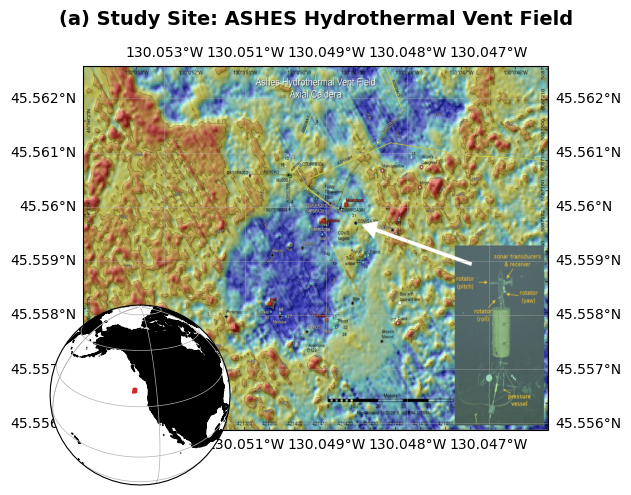

In [7]:
# ---------------------------------------------------------------------------------------
# Figure 1a: Study Site Location
# ---------------------------------------------------------------------------------------

# load image & load coordinates of the corners
fname = './ASHES2020.png'
img_extent = (-130.0540, -130.0454, 45.55587, 45.56260)
img = plt.imread(fname)

# create plot
fig, ax = plt.subplots( figsize=(6, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

feature = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor='gray'))

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5)
glb.xlabels_top = glb.ylabels_left = False

# add an inset figure for context
sub_ax = fig.add_axes([0.07, 0.1, 0.3, 0.3],
                      projection=ccrs.NearsidePerspective(central_longitude=-128, central_latitude=44,satellite_height=100000000.0/20) )

sub_ax.plot([-131, -131,  -130, -130, -131] , 
                        [ 45, 46, 46, 45, 45 ], color='tab:red',linewidth=2,  transform=ccrs.PlateCarree())
sub_ax.set_global() 
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='black')
sub_ax.add_feature(LAND)
sub_ax.gridlines(linewidth=.5)

ax.imshow(img, extent = img_extent, transform = ccrs.PlateCarree())
ax.set_title('(a) Study Site: ASHES Hydrothermal Vent Field', fontsize=14, fontweight='bold', pad=15)

# save image
plt.savefig('Figure1a_study_site.png', dpi=300, bbox_inches='tight')

plt.show();

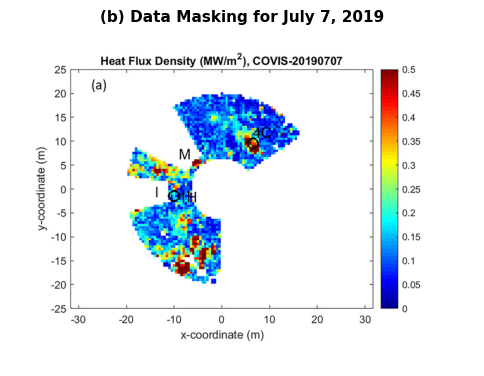

In [8]:
# ---------------------------------------------------------------------------------------
# Figure 1b: Study Site Masking
# ---------------------------------------------------------------------------------------

# --- Load image ---
fname = './masking_jackson2022.png'
img = mpimg.imread(fname)

# --- Create plot without axes ---
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)
ax.axis('off')  # Removes axes/ticks
ax.set_title('(b) Data Masking for July 7, 2019', fontsize=11, fontweight='bold')

# --- Save image ---
plt.savefig('Figure1b_study_site.png', dpi=300, bbox_inches='tight')
plt.show()


## Figure 2: Time-Series Trends

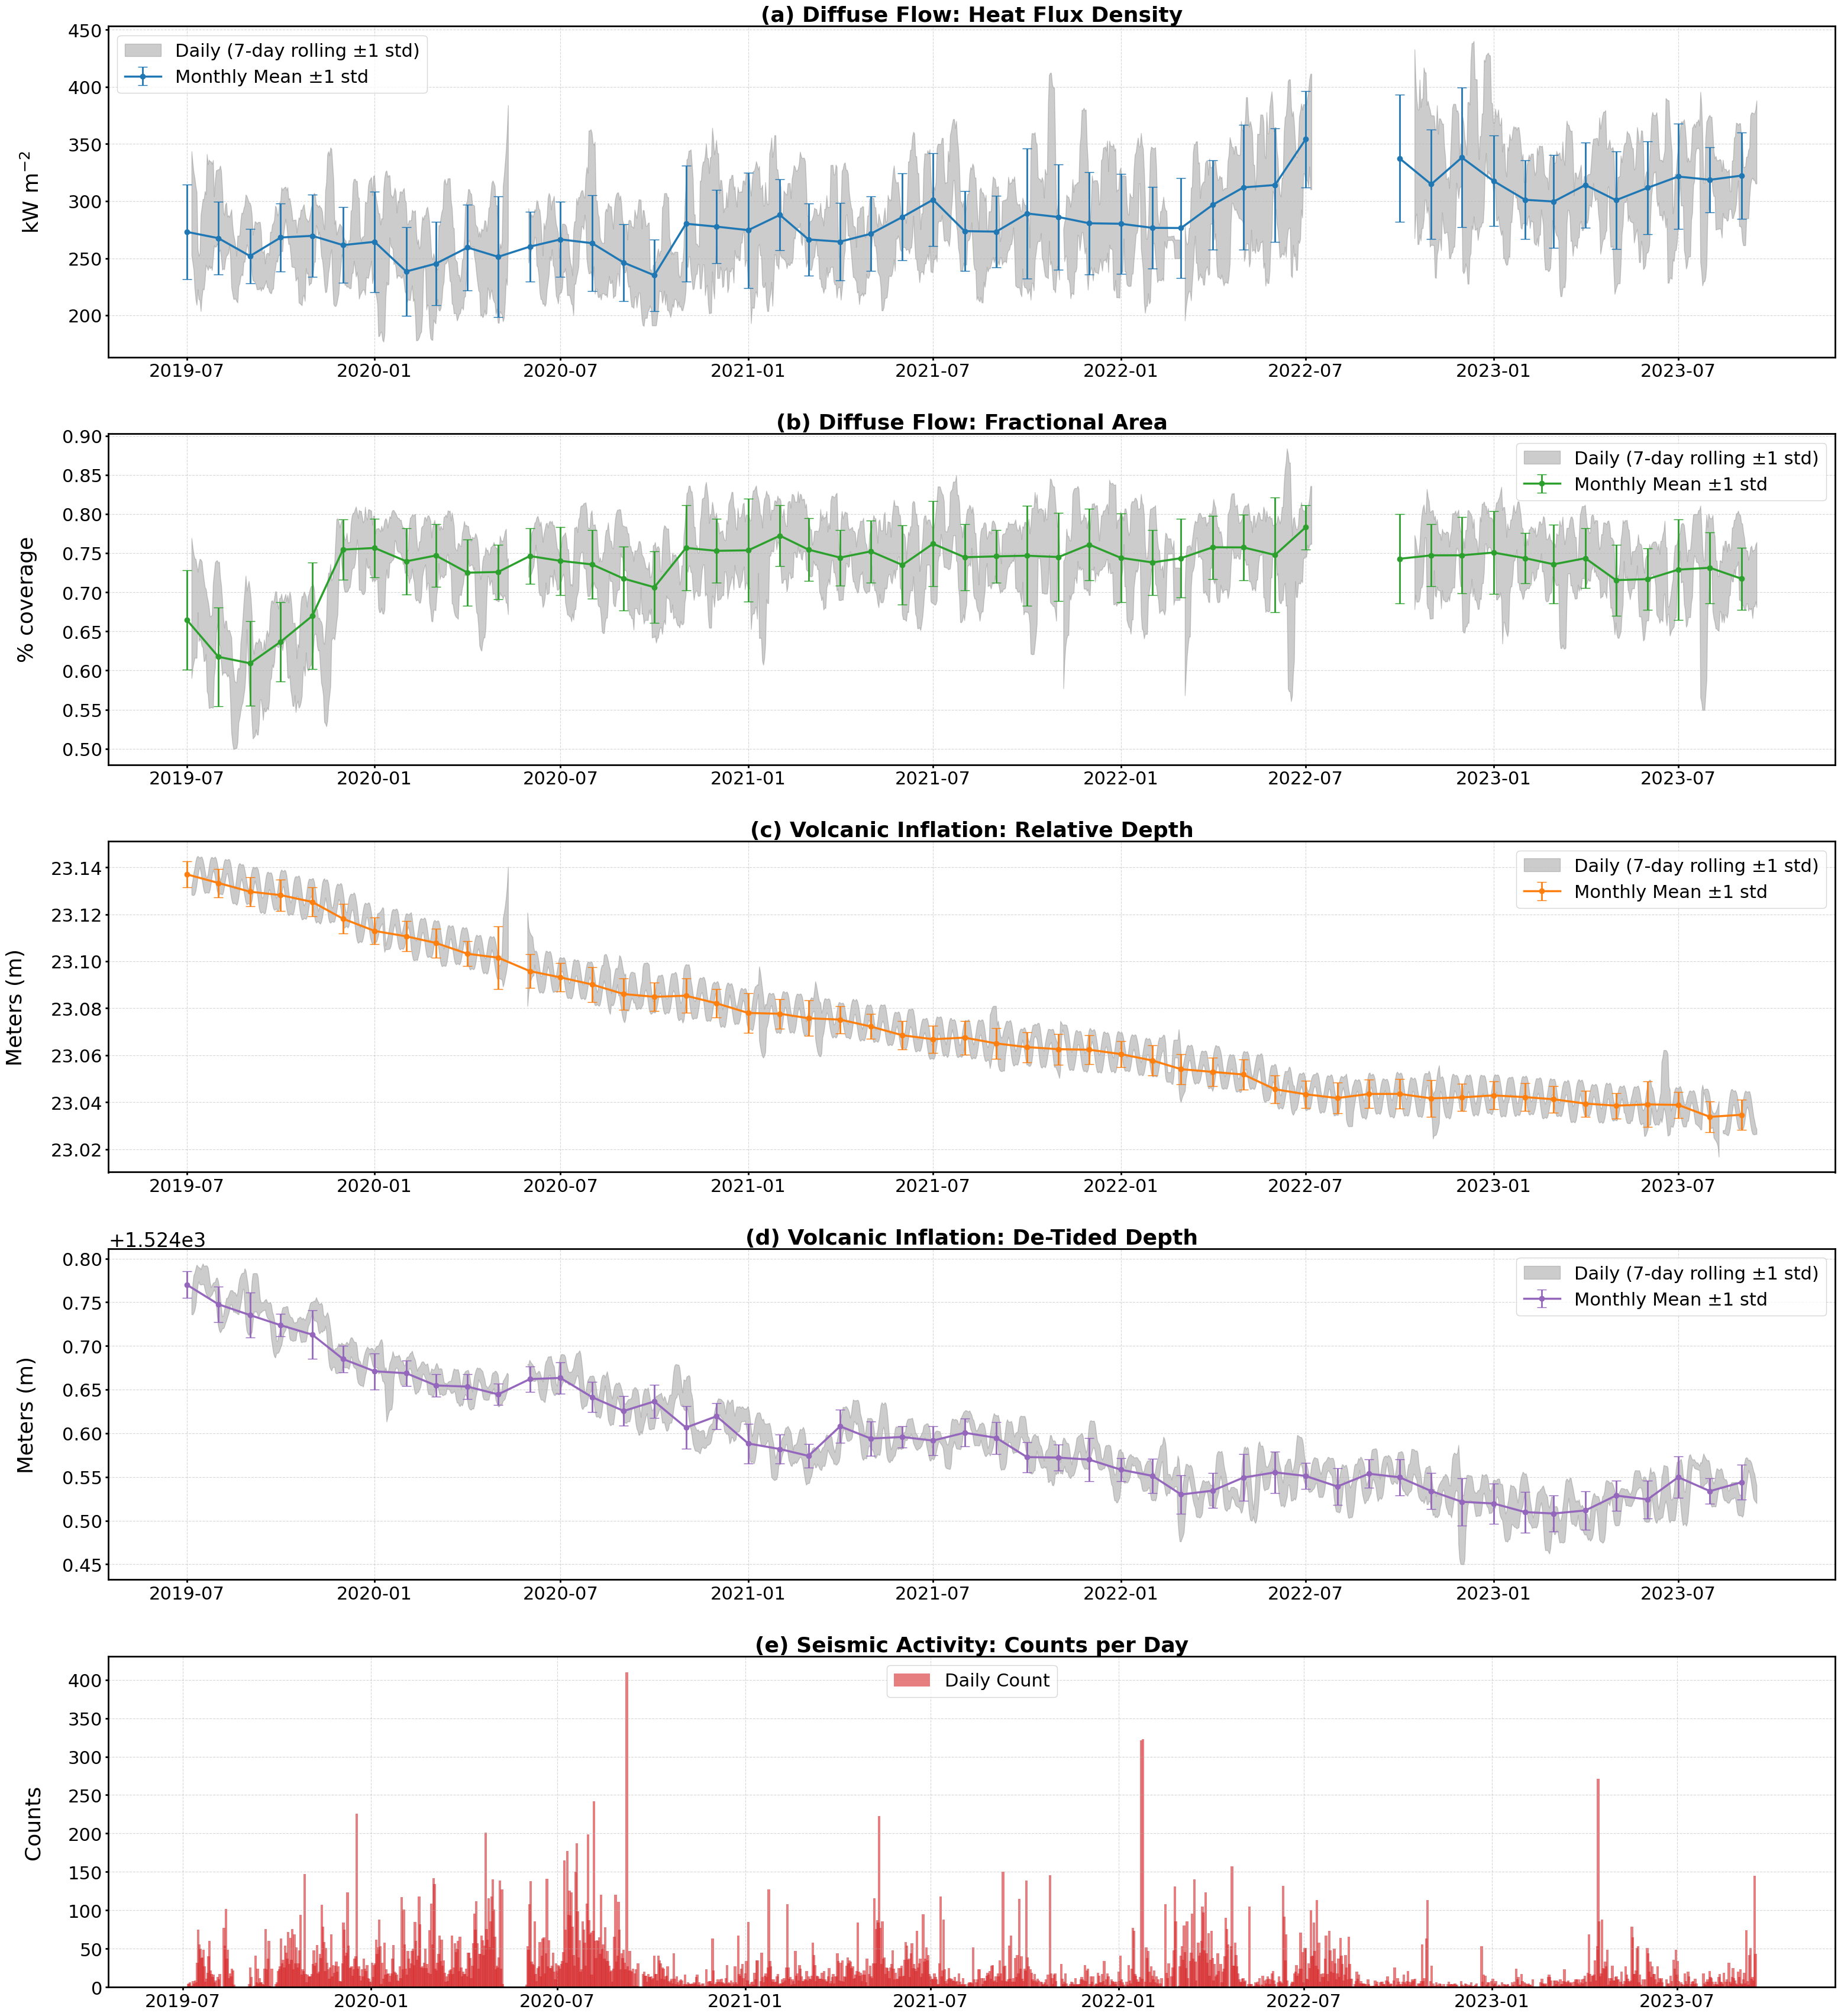

In [9]:
# ---------------------------------------------------------------------------------------
# Figure 2: Time-Series Trends
# ---------------------------------------------------------------------------------------

plt.figure(figsize=(35, 35))

# Define common style elements
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#d62728']
titles = ['(a) Diffuse Flow: Heat Flux Density',
          '(b) Diffuse Flow: Fractional Area',
          '(c) Volcanic Inflation: Relative Depth',
          '(d) Volcanic Inflation: De-Tided Depth',
          '(e) Seismic Activity: Counts per Day']
ylabels = ['kW m$^{-2}$', '% coverage', 'Meters (m)', 'Meters (m)', 'Counts']

# Subplot loop
metrics_daily = ['Heat Flux Density (kW/m²)', 'Fractional Area', 
                 'Relative Depth (m)', 'De-Tided Depth (m)', 'Seismic Count']
metrics_monthly = [monthly_hfd_stats, monthly_frac_stats, 
                   monthly_rd_stats, monthly_dtd_stats, None]

for i, metric in enumerate(metrics_daily):
    plt.subplot(5, 1, i+1)

    # Seismic Count as bar plot separately
    if metric == 'Seismic Count':
        plt.bar(combined_daily_df.index, combined_daily_df[metric], 
                color=colors[i], alpha=0.6, width=2.5, label='Daily Count')
    else:
        # Plot daily mean with shaded rolling std deviation
        daily_mean = combined_daily_df[metric].rolling(window=7, center=True, min_periods=1).mean()
        daily_std = combined_daily_df[metric].rolling(window=7, center=True, min_periods=1).std()

        plt.fill_between(combined_daily_df.index,
                         daily_mean - daily_std,
                         daily_mean + daily_std,
                         color='gray', alpha=0.4, label='Daily (7-day rolling ±1 std)')

        # Plot monthly mean with error bars
        plt.errorbar(metrics_monthly[i].index, metrics_monthly[i]['mean'],
                     yerr=metrics_monthly[i]['std'], fmt='o-', capsize=6,
                     linewidth=2.5, elinewidth=2, color=colors[i],
                     label='Monthly Mean ±1 std')

    # Set titles and labels clearly
    plt.title(titles[i], fontsize=26, fontweight='bold')
    plt.ylabel(ylabels[i], fontsize=26, labelpad=30)

    # Add grid, legend, and refine axis
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=22, loc='best')

    ax = plt.gca()

    # Format tick labels consistently across all subplots
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')
    
    # Format Relative Depth to two decimal places
    if metric == 'Relative Depth (m)':
        ax.ticklabel_format(style='plain', axis='y')

    # Format De-Tided Depth to use scientific notation with larger offset text
    if metric == 'De-Tided Depth (m)':
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(style='scientific', axis='y')
        ax.yaxis.offsetText.set_fontsize(24)
         
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(axis='both', width=2, labelsize=22)

# Final figure adjustments
plt.tight_layout(pad=4)
plt.subplots_adjust(left=0.15)
plt.savefig('Figure2_time_series.png', bbox_inches='tight', dpi=300)

plt.show()


### Figure 3: Lomb-Scargle Periodogram

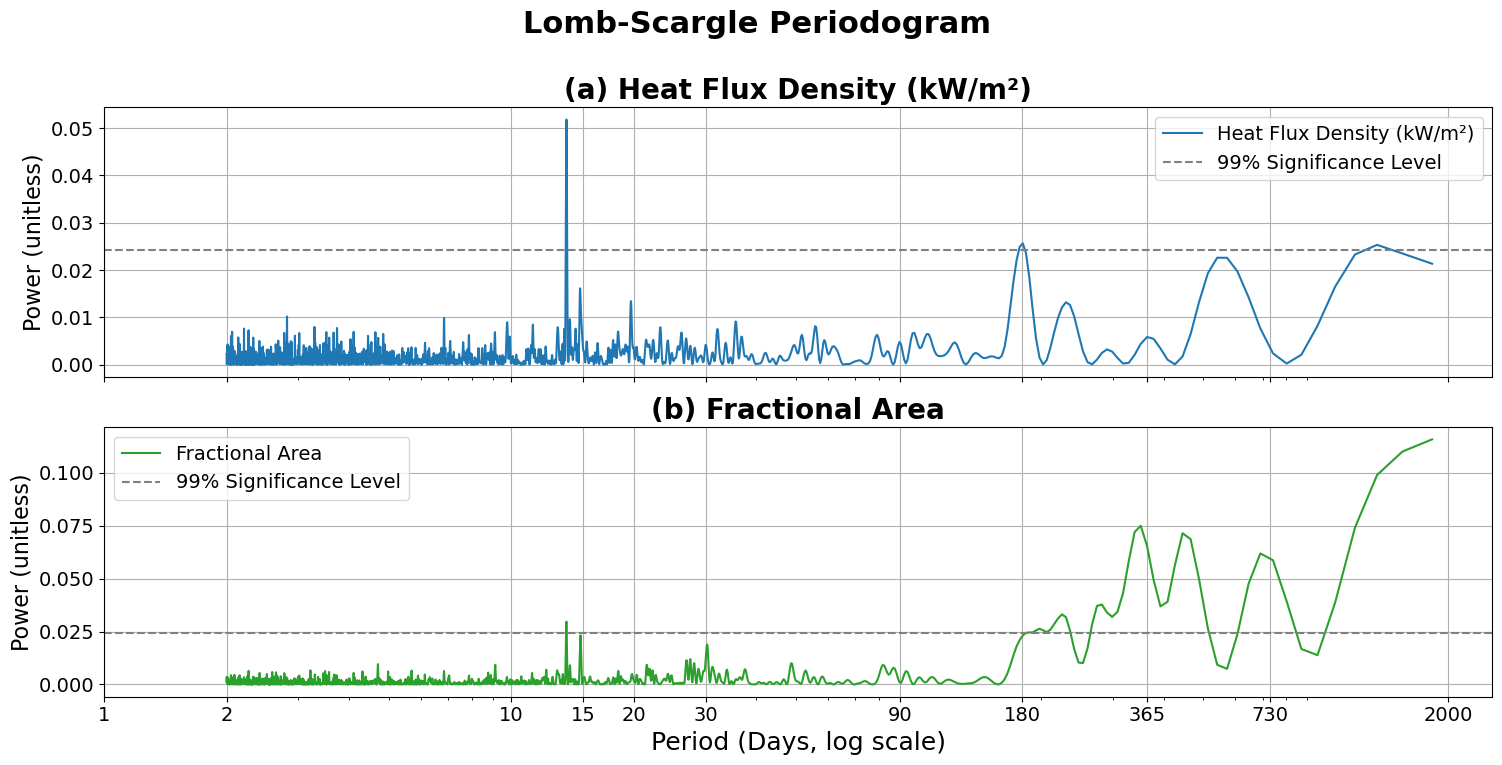

In [10]:
# ---------------------------------------------------------------------------------------
# Figure 3: Lomb-Scargle Periodogram
# ---------------------------------------------------------------------------------------

# -----------------------------------------------------------
# Load and prepare your actual dataset
# -----------------------------------------------------------
# Sort and compute time in days
ls_df = combined_daily_df.copy()
ls_df['Time'] = (ls_df.index - ls_df.index.min()).days
ls_df.dropna(inplace=True)

# -----------------------------------------------------------
# Variables and plotting parameters
# -----------------------------------------------------------
variables = {
    'Heat Flux Density (kW/m²)': {'color': '#1f77b4', 'title': '(a) Heat Flux Density (kW/m²)'},
    'Fractional Area': {'color': '#2ca02c', 'title': '(b) Fractional Area'},
}

min_period = 2         # days
max_period = 365 * 5   # 5 years
frequencies = np.linspace(1 / max_period, 1 / min_period, 5000)
periods = 1 / frequencies

custom_ticks = [1,2,10, 15, 20, 30, 90, 180, 365, 730, 2000]  # days

# -----------------------------------------------------------
# Plot Lomb-Scargle Periodograms
# -----------------------------------------------------------
fig, axes = plt.subplots(len(variables), 1, figsize=(15, 4 * len(variables)), sharex=True)
periodogram_results = {'Period (Days)': periods}

for i, (var, props) in enumerate(variables.items()):
    color = props['color']
    title = props['title']
    y_detrended = detrend(ls_df[var])
    ls = LombScargle(ls_df['Time'], y_detrended)
    power = ls.power(frequencies)
    false_alarm = ls.false_alarm_level(0.01)

    # Plot
    axes[i].plot(periods, power, color=color, label=var)
    axes[i].axhline(false_alarm, color='gray', linestyle='--', label='99% Significance Level')
    axes[i].set_ylabel('Power (unitless)', fontsize=16)
    axes[i].set_title(f'{title}', fontsize=20, fontweight='bold')
    axes[i].set_xscale('log')
    axes[i].set_xticks(custom_ticks)
    axes[i].set_xticklabels([str(t) for t in custom_ticks], fontsize=14)
    axes[i].tick_params(axis='both', labelsize=14)
    axes[i].grid(True)
    axes[i].legend(fontsize=14)

    periodogram_results[f'{var} Power'] = power

axes[-1].set_xlabel('Period (Days, log scale)', fontsize=18)

plt.suptitle('Lomb-Scargle Periodogram', fontsize=22, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.savefig('Figure3_Lomb-Scargle.png', bbox_inches='tight')
plt.show()

# -----------------------------------------------------------
# Save results to CSV
# -----------------------------------------------------------
periodogram_df = pd.DataFrame(periodogram_results)
periodogram_df.to_csv('Figure3_Lomb-Scargle_results.csv', index=False)

### Figure 4: GAM Partial Dependence

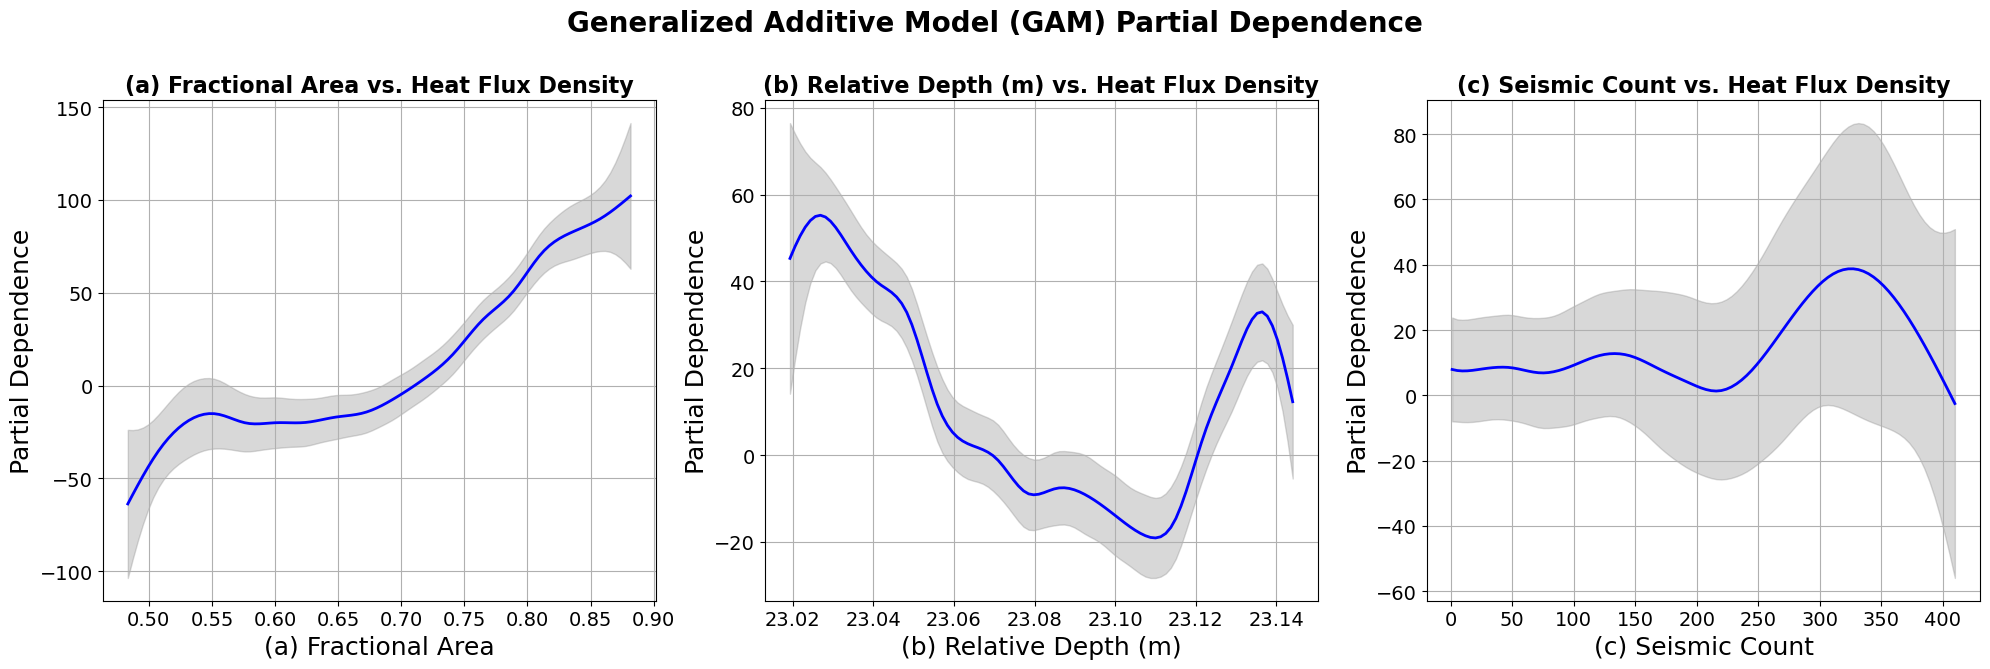

In [11]:
# ---------------------------------------------------------------------------------------
# Figure 4: GAM Partial Dependence
# ---------------------------------------------------------------------------------------

# Prepare data explicitly (excluding 'Relative Depth (m)')
df_gam_simple = combined_daily_df[[
    'Heat Flux Density (kW/m²)', 
    'Fractional Area', 
    'Relative Depth (m)', 
    'Seismic Count'
]].dropna()

x_simple = df_gam_simple[['Fractional Area', 'Relative Depth (m)', 'Seismic Count']].to_numpy()
y_simple = df_gam_simple['Heat Flux Density (kW/m²)'].to_numpy()

# Fit the simplified GAM model
gam_simple = LinearGAM(s(0) + s(1) + s(2)).fit(x_simple, y_simple)

# Generate figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
terms = ['(a) Fractional Area', '(b) Relative Depth (m)', '(c) Seismic Count']

for i, ax in enumerate(axs):
    XX = gam_simple.generate_X_grid(term=i)
    pdep, confi = gam_simple.partial_dependence(term=i, X=XX, width=0.95)
    ax.plot(XX[:, i], pdep, color='blue', linewidth=2)
    ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)

    ax.set_xlabel(terms[i], fontsize=18)
    ax.set_ylabel('Partial Dependence', fontsize=18)
    ax.set_title(f'{terms[i]} vs. Heat Flux Density', fontsize=16, fontweight='bold')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)

plt.suptitle('Generalized Additive Model (GAM) Partial Dependence', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Save high-quality figure
plt.savefig('Figure4_GAM.png', dpi=300, bbox_inches='tight')
plt.show()


## Supplementary Figures 

### Figure S1: Pearson and Spearman correlation matrices

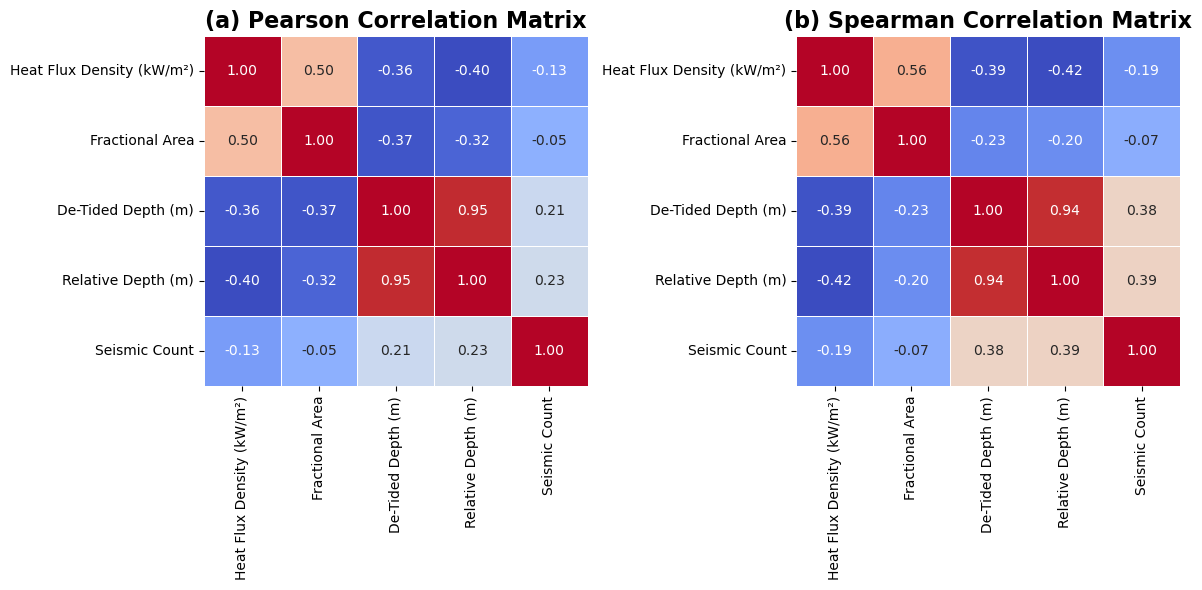

In [12]:
# ---------------------------------------------------------------------------------------
# Figure S1: Pearson and Spearman correlation matrices
# ---------------------------------------------------------------------------------------

# ---------------------------------------------------
# Prepare data explicitly (numeric columns only)
# ---------------------------------------------------
corr_df = combined_daily_df[['Heat Flux Density (kW/m²)',
                             'Fractional Area',
                             'De-Tided Depth (m)',
                             'Relative Depth (m)',
                             'Seismic Count']].dropna()

# ---------------------------------------------------
# Calculate Pearson and Spearman correlation matrices
# ---------------------------------------------------
pearson_corr = corr_df.corr(method='pearson')
spearman_corr = corr_df.corr(method='spearman')

# ---------------------------------------------------
# Plot Pearson and Spearman matrices side-by-side
# ---------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pearson heatmap
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=ax1, cbar=False)
ax1.set_title('(a) Pearson Correlation Matrix', fontsize=16, fontweight='bold')

# Spearman heatmap
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=ax2, cbar=False)
ax2.set_title('(b) Spearman Correlation Matrix', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('FigureS1_Correlation_Matrices.png', dpi=300)
plt.show()



### Figure S2: Correlation and P-values Table

In [13]:
# ---------------------------------------------------------------------------------------
# Figure S2: Correlation and P-values Table
# ---------------------------------------------------------------------------------------

# ---------------------------------------------------
# Function to calculate Pearson and Spearman correlations with p-values
# ---------------------------------------------------
def calc_corr_pval(x, y):
    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)
    return pearson_r, pearson_p, spearman_r, spearman_p

# ---------------------------------------------------
# Function to calculate correlation ratio (η²)
# ---------------------------------------------------
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements)
    category_means = {}
    counts = {}
    for cat in np.unique(categories):
        cat_measures = measurements[categories == cat]
        category_means[cat] = np.mean(cat_measures)
        counts[cat] = len(cat_measures)
    overall_mean = np.mean(measurements)
    ss_between = sum(counts[cat] * (category_means[cat] - overall_mean) ** 2 for cat in category_means)
    ss_total = sum((measurements - overall_mean) ** 2)
    return ss_between / ss_total if ss_total != 0 else 0

# ---------------------------------------------------
# Function to format p-values with significance indicators
# ---------------------------------------------------
def format_pval(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return "<0.01"
    elif p < 0.05:
        return "<0.05"
    else:
        return f"{p:.3f} ns"

# ---------------------------------------------------
# Define variables for analysis
# ---------------------------------------------------
variables = ['Fractional Area', 'De-Tided Depth (m)', 'Relative Depth (m)', 'Seismic Count']
results = []

# ---------------------------------------------------
# Bin continuous variables for correlation ratio (η²)
# ---------------------------------------------------
corr_df = corr_df.dropna(subset=['Heat Flux Density (kW/m²)'] + variables)

corr_df['FA_binned'] = pd.qcut(corr_df['Fractional Area'], q=10, labels=False)
corr_df['DD_binned'] = pd.qcut(corr_df['De-Tided Depth (m)'], q=10, labels=False)
corr_df['RD_binned'] = pd.qcut(corr_df['Relative Depth (m)'], q=10, labels=False)
corr_df['SC_binned'] = pd.qcut(corr_df['Seismic Count'], q=10, duplicates='drop', labels=False)

eta_dict = {
    'Fractional Area': correlation_ratio(corr_df['FA_binned'], corr_df['Heat Flux Density (kW/m²)']),
    'De-Tided Depth (m)': correlation_ratio(corr_df['DD_binned'], corr_df['Heat Flux Density (kW/m²)']),
    'Relative Depth (m)': correlation_ratio(corr_df['RD_binned'], corr_df['Heat Flux Density (kW/m²)']),
    'Seismic Count': correlation_ratio(corr_df['SC_binned'], corr_df['Heat Flux Density (kW/m²)']),
}

# ---------------------------------------------------
# Run analysis and compile results
# ---------------------------------------------------
for var in variables:
    p_r, p_p, s_r, s_p = calc_corr_pval(corr_df['Heat Flux Density (kW/m²)'], corr_df[var])
    eta_sq = eta_dict.get(var, np.nan)
    results.append({
        'Variable': var,
        'Pearson r': f'{p_r:.2f}',
        'Pearson p': format_pval(p_p),
        'Spearman ρ': f'{s_r:.2f}',
        'Spearman p': format_pval(s_p),
        'Correlation Ratio (η²)': f'{eta_sq:.3f}' if not np.isnan(eta_sq) else '—'
    })

# ---------------------------------------------------
# Convert to DataFrame and save
# ---------------------------------------------------
S2_results_df = pd.DataFrame(results)
S2_results_df.to_csv('FigureS2_Correlation_with_Eta.csv', index=False)

# Display the table
print('\nCombined Correlation Table with Significance Formatting:')
print(S2_results_df)



Combined Correlation Table with Significance Formatting:
             Variable Pearson r Pearson p Spearman ρ Spearman p  \
0     Fractional Area      0.50    <0.001       0.56     <0.001   
1  De-Tided Depth (m)     -0.36    <0.001      -0.39     <0.001   
2  Relative Depth (m)     -0.40    <0.001      -0.42     <0.001   
3       Seismic Count     -0.13    <0.001      -0.19     <0.001   

  Correlation Ratio (η²)  
0                  0.305  
1                  0.178  
2                  0.211  
3                  0.043  


### Figure S3: Power-law Relationship

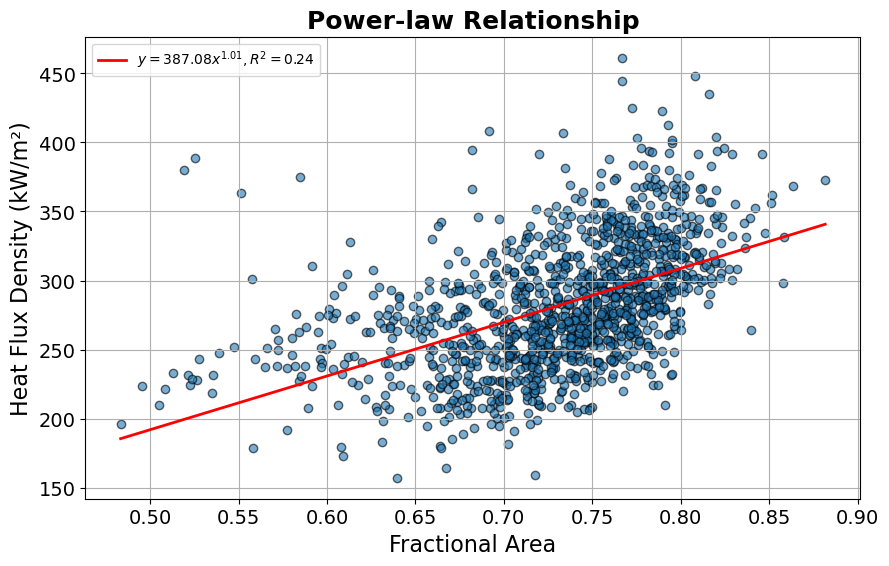

In [14]:
# ---------------------------------------------------------------------------------------
# Figure S3: Power-law Relationship for Fractional Area and Heat Flux Density
# ---------------------------------------------------------------------------------------

fractional_area = combined_daily_df['Fractional Area'].dropna()
heat_flux_density = combined_daily_df['Heat Flux Density (kW/m²)'].loc[fractional_area.index].dropna()
fractional_area, heat_flux_density = fractional_area.align(heat_flux_density, join='inner')

def power_law(x, a, b):
    return a * np.power(x, b)

params, _ = curve_fit(power_law, fractional_area, heat_flux_density)
predicted_flux = power_law(fractional_area, *params)

ss_res = np.sum((heat_flux_density - predicted_flux)**2)
ss_tot = np.sum((heat_flux_density - heat_flux_density.mean())**2)
r2 = 1 - (ss_res / ss_tot)

plt.figure(figsize=(10, 6))
plt.scatter(fractional_area, heat_flux_density, alpha=0.6, edgecolor='k')
sorted_area = np.sort(fractional_area)
plt.plot(sorted_area, power_law(sorted_area, *params), 'r-', linewidth=2,
         label=f'$y={params[0]:.2f}x^{{{params[1]:.2f}}}, R^2={r2:.2f}$')

plt.xlabel('Fractional Area', fontsize=16)
plt.ylabel('Heat Flux Density (kW/m²)', fontsize=16)
plt.title('Power-law Relationship', fontsize=18, fontweight='bold')
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Save figure
plt.savefig('FigureS3_PowerLaw.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure S4: Cross-Correlation between Fractional Area and Heat Flux Density

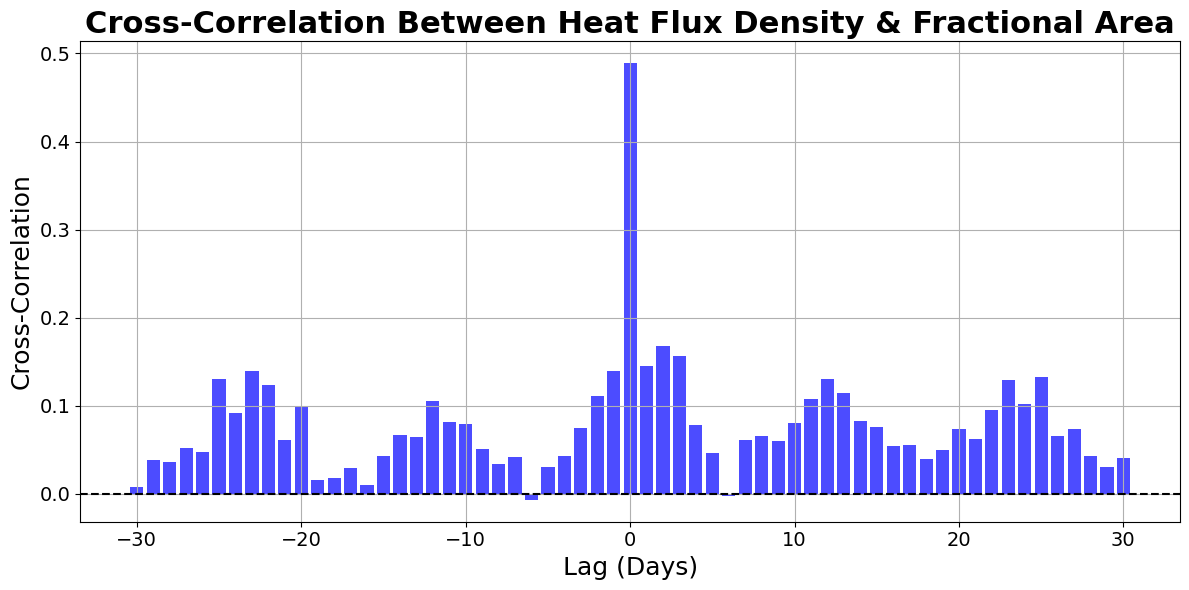

In [15]:
# ---------------------------------------------------------------------------------------
# Figure S4: Cross-Correlation between Fractional Area and Heat Flux Density
# ---------------------------------------------------------------------------------------

def symmetric_ccf_fixed(x, y, lag_range=30):
    x = np.asarray(x)
    y = np.asarray(y)
    lags = np.arange(-lag_range, lag_range + 1)
    corr = []

    for lag in lags:
        if lag < 0:
            x_lag = x[:lag]
            y_lag = y[-lag:]
        elif lag > 0:
            x_lag = x[lag:]
            y_lag = y[:-lag]
        else:
            x_lag = x
            y_lag = y

        if len(x_lag) > 2:
            r = np.corrcoef(x_lag, y_lag)[0, 1]
        else:
            r = np.nan
        corr.append(r)

    return lags, np.array(corr)

# Clean and center your data
df_valid = combined_daily_df[['Heat Flux Density (kW/m²)', 'Fractional Area']].dropna()
x = df_valid['Heat Flux Density (kW/m²)'] - df_valid['Heat Flux Density (kW/m²)'].mean()
y = df_valid['Fractional Area'] - df_valid['Fractional Area'].mean()

# Compute symmetric cross-correlation
lags, corr = symmetric_ccf_fixed(x, y, lag_range=30)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(lags, corr, color='blue', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Lag (Days)', fontsize=18)
plt.ylabel('Cross-Correlation', fontsize=18)
plt.title('Cross-Correlation Between Heat Flux Density & Fractional Area', fontsize=22, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FigureS4_Cross_Correlation.png', dpi=300, bbox_inches='tight')
plt.show()